In [1]:
## Get packages ready
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


import tensorboard
import tensorflow as tf

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [2]:
player_stats_and_awards = pd.read_csv('../data/player_stats_and_awards.csv')

## Select the players who are ineligible for the Hall of Fame in 2019 for later
current_player_stats_and_awards = player_stats_and_awards.loc[player_stats_and_awards['Year_end'] > 2015];

## Pick players who have entire careers in the league since the addition of the 3-point line, 
## and who have retired in time to be eligible for the Hall of Fame in 2019.

condition = (player_stats_and_awards['Year_end'] <= 2015) & (player_stats_and_awards['Year_start'] >= 1982);
player_stats_and_awards = player_stats_and_awards.loc[condition];


# Drop a specific player who made the HOF based on performance in FIBA international play
player_stats_and_awards.drop(169, axis = 0, inplace = True)

In [3]:
## We define our data matrix
X = player_stats_and_awards.drop(["Player","HOF",'Length', 'Birth Year', 'Year_start', 'Year_end'], axis = 1)
y = np.array(player_stats_and_awards["HOF"])

## Feature scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

C:\Users\vnpre\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\vnpre\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


# Validation curves and Hyperparameter selection

We will begin by generating some validation curves over hyperparameters that control the depth and number of hidden units per layer in our neural network.

In [4]:
## Fix random seed for reproducibility
seed = 7
np.random.seed(seed)

## Some helper functions
eps = 1e-8;
def f1(x):
    return(2*(1/(x[0] + eps) + 1/(x[1] + eps))**(-1))

def make_empty_dict(keys):
    return({key: [] for key in keys})


## Define split-fold cross validation sets
split = 4;
kfold = StratifiedKFold(n_splits=split, shuffle=False, random_state=seed)

n_units_range = [x for x in range(10, 110, 10)]
n_layers_range = [0, 1, 2, 3, 4] ## If you want to change this, you need to add the models into the function hidden_layers_validation


## This function will generate the training and 'split'-fold stratified cross-validation performance metrics
## over neural networks with different numbers of hidden units.
def hidden_units_validation(n_units_range, drop_reg):
    
    do = 0
    if drop_reg:
        do = 1
    
    ## Some dicts to store values
    training_performance = make_empty_dict(n_units_range)
    cv_performance = make_empty_dict(n_units_range)

    train_scores_mean = make_empty_dict(n_units_range)
    train_scores_std = make_empty_dict(n_units_range)

    cv_scores_mean = make_empty_dict(n_units_range)
    cv_scores_std = make_empty_dict(n_units_range)

    ## Loop over the range of hidden units we are probing
    for n_units in n_units_range: 
        
        ## Produce the model, with one hidden layer
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(n_units, activation=tf.nn.sigmoid),
            tf.keras.layers.Dropout(0.2*do),
            #tf.keras.layers.Dense(n_units, activation=tf.nn.sigmoid),
            tf.keras.layers.Dense(2, activation=tf.nn.softmax)
            ])
        
        ## Compile and fit to the training data
        model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
        
        ## k-fold stratified cross validataion
        for train, cv in kfold.split(X, y):

            ## Fit the model
            model.fit(X[train], y[train], epochs=100, verbose=0)
        
            output = model.predict(X[train])[:,1];
            output_cv = model.predict(X[cv])[:,1];
        
            training_performance[n_units].append(model.evaluate(X[train], y[train]) + [f1((sum(y[train]*(1*(output >= 0.5)))/sum(1*(output >= 0.5)), sum(y[train]*(1*(output >= 0.5)))/sum(y[train]) ))] ) 
            cv_performance[n_units].append(model.evaluate(X[cv], y[cv]) + [f1((sum(y[cv]*(1*(output_cv >= 0.5)))/sum(1*(output_cv >= 0.5)),sum(y[cv]*(1*(output_cv >= 0.5)))/sum(y[cv]) )) ] )  
    
        ## Average and take std over the 'split' iterations of this process
        cv_scores_mean[n_units] = np.mean(np.array(cv_performance[n_units]), axis = 0)
        cv_scores_std[n_units] = np.std(np.array(cv_performance[n_units]), axis = 0)
    
        train_scores_mean[n_units] = np.mean(np.array(training_performance[n_units]), axis = 0)
        train_scores_std[n_units] = np.std(np.array(training_performance[n_units]), axis = 0)
        
    return(train_scores_mean, train_scores_std, cv_scores_mean, cv_scores_std)
    

## This function is just like the above, except now we are exploring the effect of depth on performance
def hidden_layers_validation(n_layers_range, drop_reg):
    
    do = 0
    
    if drop_reg:
        do = 1

    
    ## Dicts for storing data
    training_performance = make_empty_dict(n_layers_range)
    cv_performance = make_empty_dict(n_layers_range)

    train_scores_mean = make_empty_dict(n_layers_range)
    train_scores_std = make_empty_dict(n_layers_range)

    cv_scores_mean = make_empty_dict(n_layers_range)
    cv_scores_std = make_empty_dict(n_layers_range)

    ## You are free to choose this, or use the output of the previous function.
    hidden_units = 60

    ## Not sure if there is a cleaner way to vary the number of layers in a model. 
    ## Here I just build them explicitly.
    model_0 = tf.keras.models.Sequential([
        tf.keras.layers.Dense(2, activation=tf.nn.softmax)
        ])


    model_1 = tf.keras.models.Sequential([
        tf.keras.layers.Dense(hidden_units, activation=tf.nn.sigmoid),
        tf.keras.layers.Dropout(0.2*do),
        tf.keras.layers.Dense(2, activation=tf.nn.softmax)
        ])

    model_2 = tf.keras.models.Sequential([
        tf.keras.layers.Dense(hidden_units, activation=tf.nn.sigmoid),
        tf.keras.layers.Dropout(0.2*do),
        tf.keras.layers.Dense(hidden_units, activation=tf.nn.sigmoid),
        tf.keras.layers.Dropout(0.2*do),
        tf.keras.layers.Dense(2, activation=tf.nn.softmax)
        ])

    model_3 = tf.keras.models.Sequential([
        tf.keras.layers.Dense(hidden_units, activation=tf.nn.sigmoid),
        tf.keras.layers.Dropout(0.2*do),
        tf.keras.layers.Dense(hidden_units, activation=tf.nn.sigmoid),
        tf.keras.layers.Dropout(0.2*do),
        tf.keras.layers.Dense(hidden_units, activation=tf.nn.sigmoid),
        tf.keras.layers.Dropout(0.2*do),
        tf.keras.layers.Dense(2, activation=tf.nn.softmax)
        ])
    
    model_4 = tf.keras.models.Sequential([
        tf.keras.layers.Dense(hidden_units, activation=tf.nn.sigmoid),
        tf.keras.layers.Dropout(0.2*do),
        tf.keras.layers.Dense(hidden_units, activation=tf.nn.sigmoid),
        tf.keras.layers.Dropout(0.2*do),
        tf.keras.layers.Dense(hidden_units, activation=tf.nn.sigmoid),
        tf.keras.layers.Dropout(0.2*do),
        tf.keras.layers.Dense(hidden_units, activation=tf.nn.sigmoid),
        tf.keras.layers.Dropout(0.2*do),
        tf.keras.layers.Dense(2, activation=tf.nn.softmax)
        ])
    
    ## This is just a counter variable
    n_layers = 0;

    ## Loop over different models
    for layer_model in [model_0, model_1, model_2, model_3, model_4]:
    
        ## Compile and fit to the training data
        layer_model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
        
        ## Stratified k-fold cross validation
        for train, cv in kfold.split(X, y):
    
            ## Fit the model
            layer_model.fit(X[train], y[train], epochs=100, verbose=0)
        
            ## Predict with the model
            output = layer_model.predict(X[train])[:,1];
            output_cv = layer_model.predict(X[cv])[:,1];
    
            ## Record the performance on both training and cv data. We calculate precision and recall directly here
        
            training_performance[n_layers].append( layer_model.evaluate(X[train], y[train]) + [f1(  (sum(y[train]*(1*(output >= 0.5)))/sum(1*(output >= 0.5)), sum(y[train]*(1*(output >= 0.5)))/sum(y[train]) ) )] ) 
            cv_performance[n_layers].append(layer_model.evaluate(X[cv], y[cv]) + [f1((sum(y[cv]*(1*(output_cv >= 0.5)))/sum(1*(output_cv >= 0.5)),sum(y[cv]*(1*(output_cv >= 0.5)))/sum(y[cv]) )) ] )  
    
        ## Average and take std over the 'split' iterations of this process
        cv_scores_mean[n_layers] = np.mean(np.array(cv_performance[n_layers]), axis = 0)
        cv_scores_std[n_layers] = np.std(np.array(cv_performance[n_layers]), axis = 0)
    
        train_scores_mean[n_layers] = np.mean(np.array(training_performance[n_layers]), axis = 0)
        train_scores_std[n_layers] = np.std(np.array(training_performance[n_layers]), axis = 0)
    
        n_layers += 1
        
        if n_layers == n_layers_range[-1] + 1:
            return(train_scores_mean, train_scores_std, cv_scores_mean, cv_scores_std)
        
        print('Moving on to ' +  str(n_layers) + ' layers')
    
    
## This function takes the output of the x_validation functions and turns them into lists for plotting. 
## Probably a better way to do this.

def scrape_dicts(train_scores_mean, train_scores_std, cv_scores_mean, cv_scores_std):
    
    ## Lists to store info
    train_f1 = []
    train_f1_std = []

    cv_f1 = []
    cv_f1_std = []
    
    
    for key in train_scores_mean.keys():
        train_f1.append(train_scores_mean[key][-1])
        train_f1_std.append(train_scores_std[key][-1])
    
        cv_f1.append(cv_scores_mean[key][-1])
        cv_f1_std.append(cv_scores_std[key][-1])
        
    return(train_f1, train_f1_std, cv_f1, cv_f1_std)

## This function just plots the data

def validation_curve(n_range, train_f1, train_f1_std, cv_f1, cv_f1_std):
    plt.plot(n_range, train_f1, label = 'Training', color = 'darkorange', marker = 'o')
    plt.plot(n_range, cv_f1, label = 'Cross-Validation', color = 'navy', marker = 'o')


    plt.fill_between(n_range, np.array(train_f1) - np.array(train_f1_std),
                 np.array(train_f1) + np.array(train_f1_std), alpha=0.2,
                 color="darkorange")

    plt.fill_between(n_range, np.array(cv_f1) - np.array(cv_f1_std),
                 np.array(cv_f1) + np.array(cv_f1_std), alpha=0.2,
                 color="navy")

In [12]:
## Create and store the depth validation curve info
hl_val_data = scrape_dicts(*hidden_layers_validation(n_layers_range, drop_reg = True))

477/477 [==============================] - 0s 17us/step
Moving on to 1 layers
477/477 [==============================] - 0s 25us/step
Moving on to 2 layers
477/477 [==============================] - 0s 29us/step
Moving on to 3 layers
477/477 [==============================] - 0s 29us/step
Moving on to 4 layers
477/477 [==============================] - 0s 33us/step


In [13]:
## Create and store the hidden units validation curve info
hu_val_data = scrape_dicts(*hidden_units_validation(n_units_range, drop_reg = True))

477/477 [==============================] - 0s 36us/step


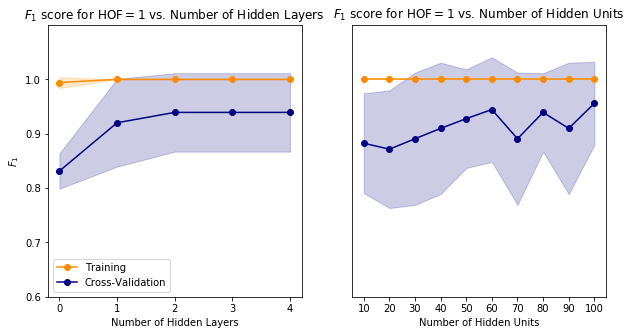

In [21]:
# create plot
fig, ax = plt.subplots(figsize=(10, 5))
#index = np.arange(n_groups)

ax1 = plt.subplot(1,2,1)


plt.title('$F_1$ score for HOF$ = 1$ vs. Number of Hidden Layers ');
plt.xlabel('Number of Hidden Layers')
plt.xticks((0,1,2,3,4))
plt.ylabel('$F_1$')
plt.ylim(0.6, 1.1)
plt.yticks( np.linspace(0.6, 1, 5))
validation_curve(n_layers_range, *hl_val_data)
plt.legend(loc = 'lower left')
#plt.savefig('./figures/neural-network/61_unit_HLVC.png')


ax2 = plt.subplot(1,2,2)
plt.title('$F_1$ score for HOF$ = 1$ vs. Number of Hidden Units ');
plt.xlabel('Number of Hidden Units')
plt.xticks(n_units_range)
#plt.ylabel('$F_1$')
plt.ylim(0.6, 1.1)
ax2.set_yticks([])
validation_curve(n_units_range, *hu_val_data)
#plt.legend()
plt.savefig('../figures/neural-network/NNVC.png')

This tells us that the optimal number of layers (subject to the choice of hidden units) is 3, but this is not a significant improvement over a neural network with 1 layer, or simply a logistic regression model (NN with 0 hidden layers).

We see a peak in the CV performance at 60 and 70 units per layer. However, the persistent gap between training and CV data and saturation of training score indicate we may be overfitting. We can introduce dropout to combat this, or do batch regularization. As it stands, we will proceed to show that there is not much point in working harder on this Neural network, as it will fail to produce results better than a logistic regression. 

In [15]:
hu_val_data[2][3] == hl_val_data[2][1]

False

# Predicting Future Hall of Famers

After choosing a model with the above diagnostic information in mind, we turn to predicting which players currently in the league could make it into the HOF.

In [6]:
hidden_units = 60;

final_model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(hidden_units, activation=tf.nn.sigmoid),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(hidden_units, activation=tf.nn.sigmoid),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(hidden_units, activation=tf.nn.sigmoid),
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(hidden_units, activation=tf.nn.sigmoid),
        tf.keras.layers.Dense(2, activation=tf.nn.softmax)
        ])

## Compile and fit to the training data
final_model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
        
## Fit the model to the full set of labelled data
final_model.fit(X, y, epochs=500, verbose=0)

In [7]:
## Now we will predict the probabilities of currently ineligible players to become enshrined in the HOF

in_df = current_player_stats_and_awards.copy();
in_data = in_df.drop(["Player","HOF",'Length', 'Birth Year', 'Year_start', 'Year_end'], axis = 1)

## Feature scaling
in_data = preprocessing.scale(in_data)

predictions = final_model.predict(in_data)
in_df['Predictions'] = 1*(predictions[:,1] >= 0.5)

in_df[['Player', 'Predictions', 'AllStar', 'VORP']].sort_values(['AllStar'], ascending = False).round(decimals = 3).head(30)

C:\Users\vnpre\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  import sys


,Player,Predictions,AllStar,VORP
1557,Kobe Bryant,1,18.0,72.3
2517,Tim Duncan,1,15.0,89.4
1520,Kevin Garnett,1,15.0,94.1
1628,LeBron James,1,15.0,116.0
745,Dirk Nowitzki,1,14.0,65.8
807,Dwyane Wade,1,13.0,58.0
419,Chris Bosh,1,11.0,27.5
366,Carmelo Anthony,0,10.0,29.4
2044,Paul Pierce,1,10.0,61.4
1517,Kevin Durant,1,10.0,46.9


We sort by 'AllStar' in light of the conclusions of the feature selection investigation. There are only a handful
of surprises here. Carmelo Anthony, Vince Carter, Pau Gasol are all very famous players who are not predicted to make it into
the HOF

# PCA Analysis

In order to get a sense of how our training and test performance compare, we plot the data by using a few of the principle components in two and three dimensions. This allows us to see some structure. First, we identify legendary players who fall well outside the point cloud generated by the NBA as a whole. We also see a region of parameter space where our algorithm does not do a good job of generalizing from training to test data. This can be improved by increasing the amount of training data.

C:\Users\vnpre\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:13: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  del sys.path[0]
C:\Users\vnpre\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:65: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


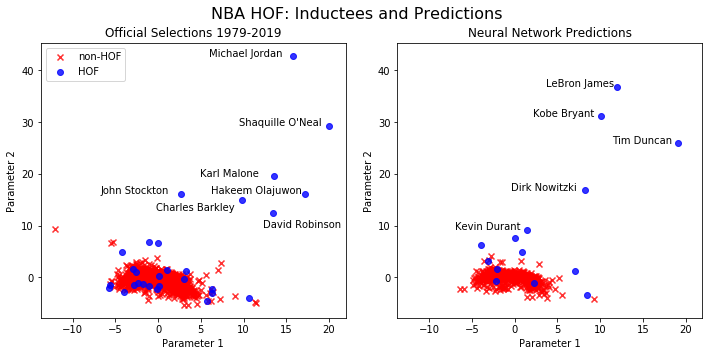

In [34]:
X_in = player_stats_and_awards.drop(['HOF','Length', 'Birth Year', 'Year_start', 'Year_end'], axis = 1)
y_in = player_stats_and_awards['HOF']

X_in.reset_index(drop = True, inplace = True)
y_in.reset_index(drop = True, inplace = True)

## Scale and transform data to PCA representation
pca = PCA(n_components=5)

## These two choose which principle components to plot. Select anything from 0 - 4.
comp1, comp2 = 2,3

X_scaled = scaler.transform(X_in.drop(['Player'], axis = 1))
X_scaled = pca.fit_transform(X_scaled)

# data to plot
X_in_1 = X_scaled[y_in==1]
X_in_0 = X_scaled[y_in==0]

# create plot
fig, ax = plt.subplots(figsize=(10, 5))

ax1 = plt.subplot(1,2,1)
opacity = 0.8

## Plot training data
plt.scatter(X_in_0[:,comp1], X_in_0[:,comp2], 
            alpha=opacity,
            color='r',
            marker = 'x',label='non-HOF')
plt.scatter(X_in_1[:,comp1], X_in_1[:,comp2],
            alpha=opacity,
            color='b',
            marker = 'o',label='HOF')


#plt.xlabel('PC ' + str(comp1))
#plt.ylabel('PC ' + str(comp2))

plt.xlabel('Parameter 1')
plt.ylabel('Parameter 2')

plt.title('Official Selections 1979-2019')
plt.legend()

## Label outstanding players
for x in X_in[ (y_in == 1) & (X_scaled[:,comp1] > 0) & (X_scaled[:,comp2] > 10 )].index:
    name = X_in.loc[x, 'Player']
    offset = 90*(len(name)/16)**0.5
    if name == 'David Robinson':
        ax1.annotate( name,(X_scaled[x,comp1], X_scaled[x,comp2]), xytext=(-10, -15), textcoords = "offset points") 
    elif name == 'Charles Barkley':
        ax1.annotate( name,(X_scaled[x,comp1], X_scaled[x,comp2]), xytext=(-offset + 1, -10), textcoords = "offset points") 
    elif name == 'Hakeem Olajuwon':
        ax1.annotate( name,(X_scaled[x,comp1], X_scaled[x,comp2]), xytext=(-offset - 7, 0), textcoords = "offset points") 
    else:
        ax1.annotate( name,(X_scaled[x,comp1], X_scaled[x,comp2]), xytext=(-offset, 0), textcoords = "offset points") 

## Repeat the above for test data   
ax2 = plt.subplot(1,2,2, sharex = ax1, sharey = ax1)

X_in = in_df
y_in = in_df['Predictions']

X_scaled = pca.transform(scaler.transform(X_in.drop(['Player','HOF','Predictions','Length', 'Birth Year', 'Year_start', 'Year_end'], axis = 1)))


X_in.reset_index(drop = True, inplace = True)
y_in.reset_index(drop = True, inplace = True)

# data to plot
X_in_1 = X_scaled[y_in==1]
X_in_0 = X_scaled[y_in==0]

opacity = 0.8

plt.scatter(X_in_0[:,comp1], X_in_0[:,comp2],
            alpha=opacity,
            color='r',
            marker = 'x',label='non-HOF')

plt.scatter(X_in_1[:,comp1], X_in_1[:,comp2],
            alpha=opacity,
            color='b',
            marker = 'o',label='Predicted HOF')


#plt.xticks(index)
#plt.xlabel('PC ' + str(comp1))
#plt.ylabel('PC ' + str(comp2))

plt.xlabel('Parameter 1')
plt.ylabel('Parameter 2')

plt.title('Neural Network Predictions')
#plt.legend()
fig.suptitle("NBA HOF: Inductees and Predictions", fontsize=16)

 
for x in X_in[ (y_in == 1) & (X_scaled[:,comp1] > 0) & (X_scaled[:,comp2] >  7)].index:
    name = X_in.loc[x, 'Player']
    offset = 90*(len(name)/19)**0.5
    ax2.annotate( name,(X_scaled[x,comp1], X_scaled[x,comp2]), xytext=(-offset, 0), textcoords = "offset points") 

plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.savefig('../figures/neural-network-pca/two-rep-feature.png')
plt.show()

C:\Users\vnpre\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
C:\Users\vnpre\AppData\Local\Programs\Python\Python36\lib\site-packages\matplotlib\collections.py:874: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
C:\Users\vnpre\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:41: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
C:\Users\vnpre\AppData\Local\Programs\Python\Python36\lib\site-packages\matplotlib\collections.py:874: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


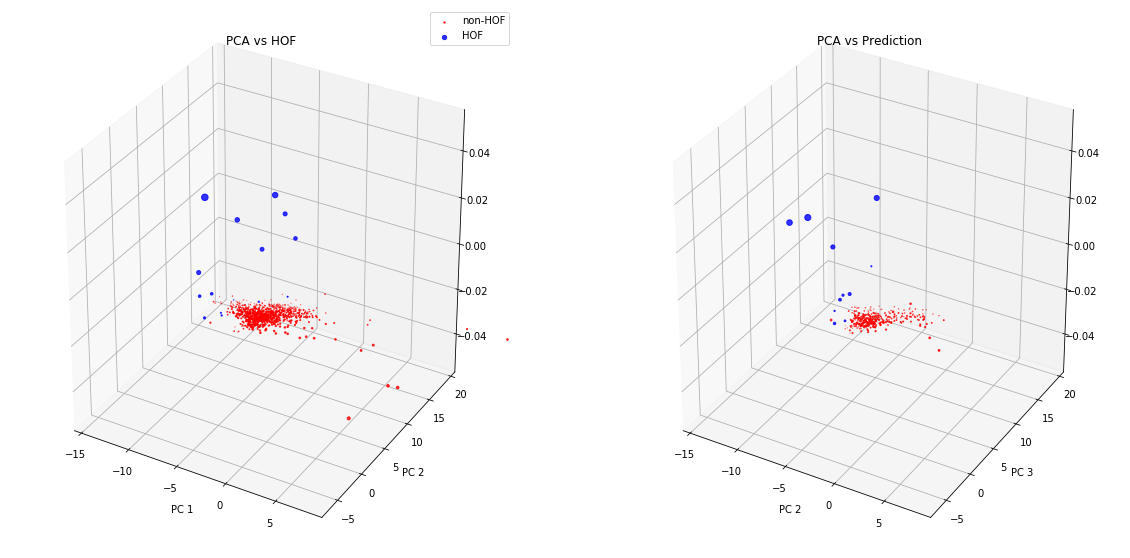

In [10]:
## The same as above, but three dimensional plot. 
## Not as easy to make inferences from this, but 
## it helps decide which pairs of PCs are useful.

X_in = player_stats_and_awards.drop(['Player','HOF','Length', 'Birth Year', 'Year_start', 'Year_end'], axis = 1)
y_in = player_stats_and_awards['HOF']

X_scaled = scaler.transform(X_in)
X_scaled = pca.fit_transform(X_scaled)

# data to plot
X_in_1 = X_scaled[y_in==1]
X_in_0 = X_scaled[y_in==0]
 
# create plot
fig, ax = plt.subplots(figsize=(20, 10))
#index = np.arange(n_groups)

ax1 = plt.subplot(1,2,1,projection='3d')
opacity = 0.8

plt.scatter(X_in_0[:,1], X_in_0[:,2], X_in_0[:,3],
            alpha=opacity,
            color='r',
            marker = 'o',label='non-HOF')
plt.scatter(X_in_1[:,1], X_in_1[:,2], X_in_1[:,3],
            alpha=opacity,
            color='b',
            marker = 'o',label='HOF')


#plt.xticks(index)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA vs HOF')
plt.legend(loc = 0)
 

plt.subplot(1,2,2, sharex = ax1, sharey = ax1, sharez = ax1 ,projection='3d')

X_in = pca.transform(scaler.transform(in_df.drop(['Player','HOF','Predictions','Length', 'Birth Year', 'Year_start', 'Year_end'], axis = 1)))
y_in = in_df['Predictions']


# data to plot
X_in_1 = X_in[y_in==1]
X_in_0 = X_in[y_in==0]

opacity = 0.8

plt.scatter(X_in_0[:,1], X_in_0[:,2], X_in_0[:,3],
            alpha=opacity,
            color='r',
            marker = 'o',label='non-HOF')

plt.scatter(X_in_1[:,1], X_in_1[:,2], X_in_1[:,3],
            alpha=opacity,
            color='b',
            marker = 'o',label='Predicted HOF')


#plt.xticks(index)
plt.xlabel('PC 2')
plt.ylabel('PC 3')
plt.title('PCA vs Prediction')
#plt.legend()
 
plt.tight_layout()
plt.savefig('./figures/neural-network-pca/two-rep-feature.png')

plt.show()

In [ ]:
print("This choice of components explains " + str(round(100*pca.explained_variance_ratio_.cumsum()[-1],1)) + '% of the variance') 